# Notice:
this notebook is just a visualization to indicate the aging in optimization. It is simplified and not exactly right.

# Import Things

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, cm
from matplotlib.patches import Circle, Ellipse
from mpl_toolkits.mplot3d import Axes3D, art3d
import os
import pickle
import sys
import pandas
sys.path.append('../Aging_Model')

/Users/haibinzhao/miniconda3/envs/ML/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../Aging_Model/exp_aging_model.p', 'rb') as f:
    age_generator = pickle.load(f)

# Set Random Seed

In [3]:
np.random.seed(0);
torch.manual_seed(0);

# Exemplarify a Loss function

In [4]:
x1 = np.linspace(0, 1, 1001)
x2 = np.linspace(0, 1, 1001)
dx = x1[1] - x1[0]

In [5]:
def Loss(x1, x2):
    L = np.sin(10*x1+x2) + 2*np.sin(2.5*x2+x1) + np.sin(6*x1*x2+x1) + 1.5*np.sin(12*(x1-x2)) + 2*np.sin(12*(1-x1+x2)) + 3*np.exp((-np.power(x1 - 0.4, 2.)-np.power(x2 - 0.4, 2.)) / 0.02)
    return -L + 4.760697618531012

In [6]:
LossSurface = np.zeros([x1.shape[0],x1.shape[0]])
for i in range(x1.shape[0]):
    for j in range(x1.shape[0]):
        LossSurface[i,j] = Loss(x1[i], x2[j]) 

In [7]:
np.min(LossSurface)

0.0

# Find minimal point

In [8]:
idx = np.where(LossSurface == np.min(LossSurface))
idx

(array([245]), array([466]))

In [9]:
np.min(LossSurface), np.max(LossSurface)

(0.0, 6.99256491883599)

In [10]:
x1[idx[0]], x2[idx[1]]

(array([0.245]), array([0.466]))

In [11]:
LossSurface[idx[0], idx[1]]

array([0.])

In [12]:
cm.coolwarm.set_gamma(0.5)

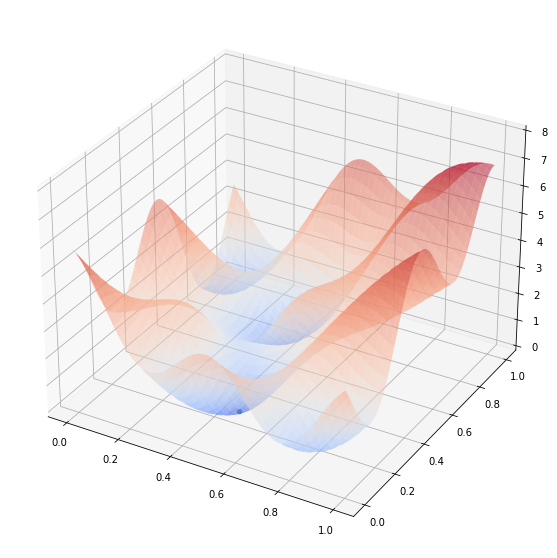

In [13]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(x1, x2)

surf = ax.plot_surface(X, Y, LossSurface, cmap=cm.coolwarm, alpha=0.5)

ax.scatter3D(x2[idx[1]], x1[idx[0]], LossSurface[idx[0], idx[1]], cmap=cm.seismic)

# # Set axes label
# ax.set_xlabel('x', labelpad=20)
# ax.set_ylabel('y', labelpad=20)
# ax.set_zlabel('z', labelpad=20)

ax.set_zlim(0, 8)
# ax.set_ylim(0.2, 0.8)



plt.show()

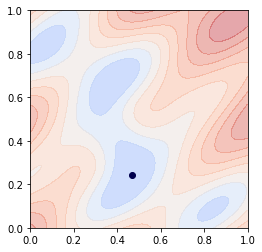

In [14]:
from matplotlib.ticker import MaxNLocator
levels = MaxNLocator(nbins=10).tick_values(np.min(LossSurface), np.max(LossSurface))
plt.contourf(X, Y, LossSurface, levels=levels, cmap=cm.coolwarm, alpha=0.4)
plt.scatter(x2[idx[1]], x1[idx[0]], cmap=cm.seismic, c=LossSurface[idx[0], idx[1]])
# plt.colorbar()
plt.gca().set_aspect('equal');
# plt.xlim([0.2, 0.8])
# plt.ylim([0., 0.6])
plt.show()

# Exemplarify a aging trajectory of w(t)

In [15]:
def aging(g, models, t):
    decays = np.array([model([t]) for model in models]).flatten()
    return g * decays

def getweights(R, models, t):
    g = 1 / R
    if models is not None:
        g = aging(g, models, t)
    g = g / np.sum(g)
    W = g[:-2]
    return W

In [16]:
np.random.seed(3)
R = np.random.rand(4)

In [17]:
def showtrace(R, age_generator):
    models = age_generator.get_models(4)

    T = np.linspace(0,1,600)
    Ws = []
    for t in T:
        W = getweights(R, models, t)
        Ws.append(W)
    Ws = np.array(Ws)
    w1 = Ws[:,0]
    w2 = Ws[:,1]
    
    return w1, w2

In [18]:
w1, w2 = showtrace(R, age_generator)

In [19]:
width = np.max(w1)-np.min(w1)
height = np.max(w2)-np.min(w2)

In [20]:
w1 = w1 / width * 0.25
w2 = w2 / height * 0.15
w1 = w1 - w1[0]
w2 = w2 - w2[0]

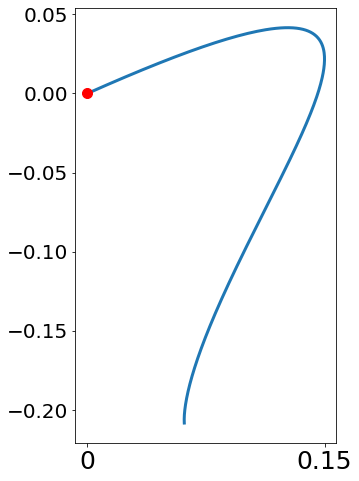

In [21]:
plt.figure(figsize=[12,8]);
plt.plot(w2, w1, '-', linewidth=3, label='$w(t)$', zorder=0);
plt.scatter(w1[0], w2[0], s=100, c='red', zorder=1);
plt.gca().set_aspect('equal');
plt.xticks([0, 0.15,], ['0', '0.15'],fontsize=25)
plt.yticks(fontsize=20)
plt.savefig(f'W_changes.pdf', format='pdf', bbox_inches='tight')

# Find the optimal in under aging

Notice that I use the brute-force search, instead of gradient-based optimization. Because this is just a simplified visualization. Not about the aging-aware training.

Notice that the aging trajectory changes with different initial point. But we ignore this change.

Notice that we didnt show the stochastic aging, but take only one example.

In [22]:
starts = []
Ls = []
for s1 in np.linspace(0,1,101):
    for s2 in np.linspace(0,1,101):
        start = np.array([s1, s2])

        w1_move = np.round(w1 + start[0], 3)
        w2_move = w2 + start[1]
        
        if (np.min(w1_move)<0 or np.min(w2_move)<0 or np.max(w1_move)>1 or np.max(w2_move)>1):
            break
        else:
            L = 0
            for i1, i2 in zip(w1_move, w2_move):
                L += Loss(i1, i2)
            L /= 600
            Ls.append(L)
            starts.append(start)
    print(start)

[0. 0.]
[0.01 0.  ]
[0.02 0.  ]
[0.03 0.  ]
[0.04 0.  ]
[0.05 0.  ]
[0.06 0.  ]
[0.07 0.  ]
[0.08 0.  ]
[0.09 0.  ]
[0.1 0. ]
[0.11 0.  ]
[0.12 0.  ]
[0.13 0.  ]
[0.14 0.  ]
[0.15 0.  ]
[0.16 0.  ]
[0.17 0.  ]
[0.18 0.  ]
[0.19 0.  ]
[0.2 0. ]
[0.21 0.86]
[0.22 0.86]
[0.23 0.86]
[0.24 0.86]
[0.25 0.86]
[0.26 0.86]
[0.27 0.86]
[0.28 0.86]
[0.29 0.86]
[0.3  0.86]
[0.31 0.86]
[0.32 0.86]
[0.33 0.86]
[0.34 0.86]
[0.35 0.86]
[0.36 0.86]
[0.37 0.86]
[0.38 0.86]
[0.39 0.86]
[0.4  0.86]
[0.41 0.86]
[0.42 0.86]
[0.43 0.86]
[0.44 0.86]
[0.45 0.86]
[0.46 0.86]
[0.47 0.86]
[0.48 0.86]
[0.49 0.86]
[0.5  0.86]
[0.51 0.86]
[0.52 0.86]
[0.53 0.86]
[0.54 0.86]
[0.55 0.86]
[0.56 0.86]
[0.57 0.86]
[0.58 0.86]
[0.59 0.86]
[0.6  0.86]
[0.61 0.86]
[0.62 0.86]
[0.63 0.86]
[0.64 0.86]
[0.65 0.86]
[0.66 0.86]
[0.67 0.86]
[0.68 0.86]
[0.69 0.86]
[0.7  0.86]
[0.71 0.86]
[0.72 0.86]
[0.73 0.86]
[0.74 0.86]
[0.75 0.86]
[0.76 0.86]
[0.77 0.86]
[0.78 0.86]
[0.79 0.86]
[0.8  0.86]
[0.81 0.86]
[0.82 0.86]
[0.83 0.86]


In [24]:
arg = np.where(Ls == np.min(Ls))[0][0]
arg

1239

In [25]:
starts[arg]

array([0.35, 0.35])

In [26]:
best_start = starts[arg]

In [27]:
w1_stupid = w1 + x1[idx[0]]
w2_stupid = w2 + x2[idx[1]]

L_stupid = []
for i1, i2 in zip(w1_stupid, w2_stupid):
    L_stupid.append(Loss(i1, i2))

In [28]:
w1_clever = w1 + best_start[0]
w2_clever = w2 + best_start[0]

L_clever = []
for i1, i2 in zip(w1_clever, w2_clever):
    L_clever.append(Loss(i1, i2))

# show the trajectories consider/not consider aging

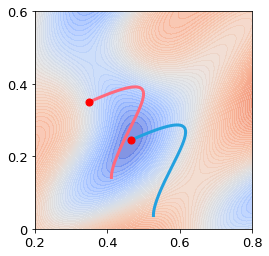

In [42]:
from matplotlib.ticker import MaxNLocator
levels = MaxNLocator(nbins=100).tick_values(np.min(LossSurface), np.max(LossSurface))
norm=plt.Normalize(0,7)
plt.contourf(X, Y, LossSurface, levels=levels, cmap = cm.coolwarm, alpha=0.7, norm=norm)
plt.plot(w2_clever, w1_clever, c=[255/255,105/255,125/255], lw=3, zorder=1)
plt.plot(w2_stupid, w1_stupid, c=[35/255, 161/255, 224/255], lw=3, zorder=1)
plt.scatter(w2_clever[0], w1_clever[0], c='red', s=50, zorder=2)
plt.scatter(w2_stupid[0], w1_stupid[0], c='red', s=50, zorder=2)
plt.gca().set_aspect('equal');
plt.xlim([0.2, 0.8])
plt.ylim([0., 0.6])
plt.xticks([0.2, 0.4, 0.6, 0.8], ['0.2', '0.4', '0.6', '0.8'],fontsize=13)
plt.yticks([0, 0.2, 0.4, 0.6], ['0', '0.2', '0.4', '0.6'],fontsize=13)
plt.savefig(f'LossValues.pdf', format='pdf', bbox_inches='tight')

In [29]:
w1 = np.hstack((w1_clever, w1_stupid))
w2 = np.hstack((w2_clever, w2_stupid))
L = np.hstack((L_clever, L_stupid))
w1.shape

(1200,)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

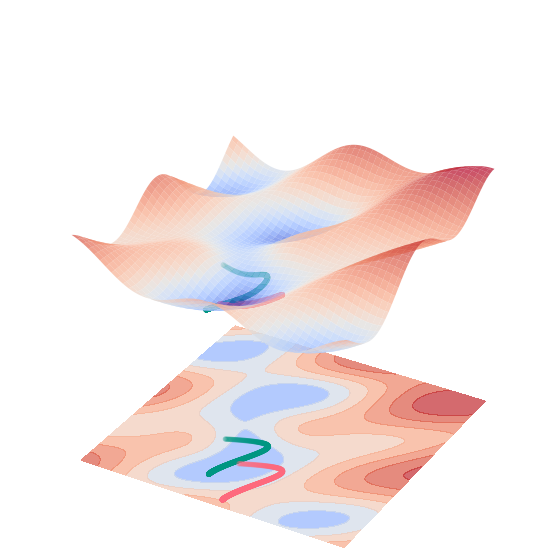

In [30]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(x1, x2)

# norm=plt.Normalize(-1,8)

surf = ax.plot_surface(X, Y, LossSurface, cmap=cm.coolwarm, alpha=0.7)


ax.scatter3D(w2_stupid, w1_stupid, L_stupid, c=[255/255,105/255,125/255])
ax.scatter3D(w2_clever, w1_clever, L_clever, c=[0/255,150/255,130/255])
# # Set axes label
# ax.set_xlabel('x', labelpad=20)
# ax.set_ylabel('y', labelpad=20)
# ax.set_zlabel('z', labelpad=20)

# ax.set_xlim(0.2, 0.8)
# ax.set_ylim(0, 0.6)
ax.set_zlim(-10, 10)
ax.set_axis_off()
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



cset = ax.contourf(X, Y, LossSurface,
                   zdir ='z',
                   offset = -15,
                   cmap = cm.coolwarm, alpha=0.7)
ax.scatter3D(w2_stupid, w1_stupid, -15, c=[255/255,105/255,125/255])
ax.scatter3D(w2_clever, w1_clever, -15, c=[0/255,150/255,130/255])



# ax.azim = 150
# ax.dist = 10
# ax.elev = 90
plt.show()